In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# creating some utility functions
def mse(y_true, y_pred):
    """
    Mean squared error loss function: L = (1/n) * sum((y_true - y_pred)^2)

    Parameters:
    -----------
    y_true : array-like
        Ground truth target values
    y_pred : array-like
        Predicted values

    Returns:
    --------
    float
        Mean squared error value
    """
    return np.mean(np.square(y_true - y_pred))

def gini_impurity(y):
    """
    Calculates the Gini Impurity for a list of class labels.
    """
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)

def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split arrays into random train and test subsets.

    Parameters:
    -----------
    X : array-like
        Features data
    y : array-like
        Target data
    test_size : float, default=0.2
        Proportion of the dataset to include in the test split
    random_state : int, default=None
        Controls the shuffling applied to the data

    Returns:
    --------
    X_train, X_test, y_train, y_test : arrays
        Train and test splits of the input data
    """
    X = np.array(X, dtype=np.float64)
    y = np.array(y, dtype=np.float64)

    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    test_samples = int(n_samples * test_size)
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

def confusion_matrix(y_true, y_pred, classes=None):
    """
    Calculate confusion matrix.

    Parameters:
    -----------
    y_true : array-like
        Ground truth target values
    y_pred : array-like
        Predicted values
    classes : array-like, default=None
        List of class labels

    Returns:
    --------
    array
        Confusion matrix where rows represent true labels and columns represent predicted labels
    """
    if classes is None:
        classes = np.unique(np.concatenate((y_true, y_pred)))

    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            cm[i, j] = np.sum((y_true == true_class) & (y_pred == pred_class))

    return cm

def accuracy(y_true, y_pred):
    """
    Calculate classification accuracy.

    Parameters:
    -----------
    y_true : array-like
        Ground truth target values
    y_pred : array-like
        Predicted values

    Returns:
    --------
    float
        Proportion of correct predictions
    """
    return np.mean(y_true == y_pred)


In [3]:
# Decision Tree Implementation
# It consists of both Decision Tree Classification and Regression as separate classes to allow for modularity

# Represents a node in the decision tree
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature          # Index of the feature to split on
        self.threshold = threshold      # Value of the feature to split at
        self.left = left                # Left subtree (<= threshold)
        self.right = right              # Right subtree (> threshold)
        self.value = value              # Value if it's a leaf node (prediction)
# Base class for Decision Tree (abstract class not to be used directly)
class DecisionTreeBase:
    def __init__(self, max_depth=100, min_samples_split=2):
        self.root = None
        self.max_depth = max_depth                      # Maximum tree depth
        self.min_samples_split = min_samples_split      # Minimum samples to allow split

    def _is_pure(self, y):
        """Check if all labels are the same (node is pure)."""
        return len(np.unique(y)) == 1

    def _split(self, X_column, threshold):
        """Splits data based on a feature column and a threshold."""
        left = np.argwhere(X_column <= threshold).flatten()
        right = np.argwhere(X_column > threshold).flatten()
        return left, right

    def _best_split(self, X, y):
        """Finds the best feature and threshold that gives the best split score."""
        best_score = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])  # Only unique values matter
            for threshold in thresholds:
                left_idx, right_idx = self._split(X[:, feature], threshold)
                if len(left_idx) == 0 or len(right_idx) == 0:
                    continue  # Skip if no split happens

                score = self._calculate_score(y[left_idx], y[right_idx])
                if score < best_score:
                    best_score = score
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        """
        Recursively builds the decision tree.
        Stops if the node is pure, max depth is reached, or not enough samples.
        """
        if (depth >= self.max_depth or
            len(y) < self.min_samples_split or
            self._is_pure(y)):
            return DecisionNode(value=self._leaf_value(y))  # Leaf node

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return DecisionNode(value=self._leaf_value(y))

        left_idx, right_idx = self._split(X[:, feature], threshold)
        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return DecisionNode(feature, threshold, left_subtree, right_subtree)

    def _predict_sample(self, x, node):
        """Traverse the tree to make a prediction for one sample."""
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        return self._predict_sample(x, node.right)

    def fit(self, X, y):
        """Fits the decision tree to the data."""
        self.root = self._build_tree(X, y, depth=0)

    def predict(self, X):
        """Predicts values for multiple samples."""
        return np.array([self._predict_sample(x, self.root) for x in X])

    # ============================
    # ABSTRACT METHODS (must be implemented by subclasses)
    # ============================

    def _calculate_score(self, left_y, right_y):
        """
        Abstract method to calculate split score.
        - In classification, it's Gini impurity.
        - In regression, it's Mean Squared Error.
        """
        raise NotImplementedError

    def _leaf_value(self, y):
        """
        Abstract method to get prediction at a leaf.
        - In classification: most frequent class.
        - In regression: mean value.
        """
        raise NotImplementedError

# ===============================
# Subclass for Classification
# ===============================
class DecisionTreeClassifier(DecisionTreeBase):
    def _calculate_score(self, left_y, right_y):
        total = len(left_y) + len(right_y)
        weighted_gini = (len(left_y) * gini_impurity(left_y) +
                         len(right_y) * gini_impurity(right_y)) / total
        return weighted_gini

    def _leaf_value(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]  # Return the most common class

# ===============================
# Subclass for Regression
# ===============================
class DecisionTreeRegressor(DecisionTreeBase):
    def _calculate_score(self, left_y, right_y):
        # Reuse imported mse to compute weighted MSE
        total = len(left_y) + len(right_y)
        weighted_mse = (len(left_y) * mse(left_y, np.full_like(left_y, np.mean(left_y))) +
                        len(right_y) * mse(right_y, np.full_like(right_y, np.mean(right_y)))) / total
        return weighted_mse

    def _leaf_value(self, y):
        return np.mean(y)  # Return the average value for regression

=== Decision Tree Classifier ===
Classifier Accuracy: 0.9500
Confusion Matrix:
 None

=== Decision Tree Regressor ===
Regressor MSE: 353.7751


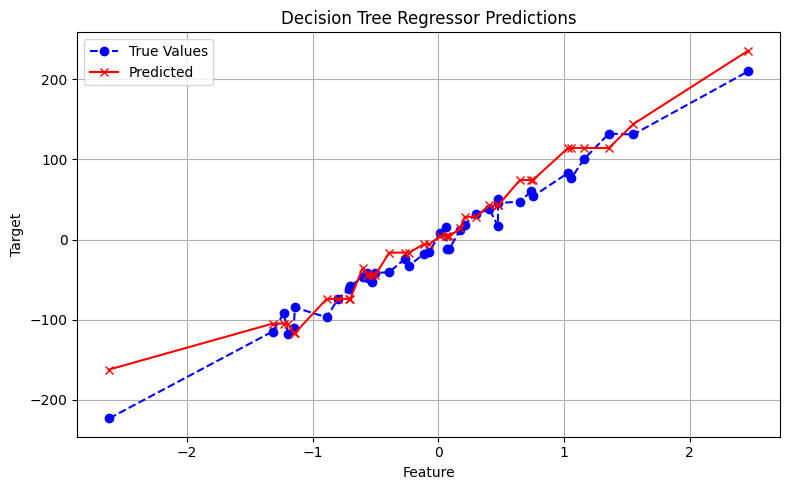

In [16]:
# Simple implementation of Decision Tree Classifier and Regressor on a random dataset generated by sklearn's make_classification and make_regression
import seaborn as sns
from sklearn.datasets import make_classification, make_regression

# def plot_confusion_matrix(cm):                                    ### Issue: Need to resolve errors with seaborn in this plot
#     plt.figure(figsize=(5, 4))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title("Confusion Matrix - Decision Tree Classifier")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.tight_layout()
#     plt.show()

def plot_regression_result(X_test, y_test, y_pred):
    # Sort for a cleaner line plot
    sorted_indices = np.argsort(X_test.ravel())
    X_test_sorted = X_test.ravel()[sorted_indices]
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    plt.figure(figsize=(8, 5))
    plt.plot(X_test_sorted, y_test_sorted, label="True Values", color="blue", marker='o', linestyle='dashed')
    plt.plot(X_test_sorted, y_pred_sorted, label="Predicted", color="red", marker='x')
    plt.title("Decision Tree Regressor Predictions")
    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------
# CLASSIFICATION EXPERIMENT
# -------------------------------
print("=== Decision Tree Classifier ===")
X_cls, y_cls = make_classification(n_samples=300, n_features=4, n_informative=2, n_redundant=0, random_state=42)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2)

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train_cls, y_train_cls)
y_pred_cls = clf.predict(X_test_cls)

acc = accuracy(y_test_cls, y_pred_cls)
print(f"Classifier Accuracy: {acc:.4f}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
print("Confusion Matrix:\n", cm)
#plot_confusion_matrix(cm)

# -------------------------------
# REGRESSION EXPERIMENT
# -------------------------------
print("\n=== Decision Tree Regressor ===")
X_reg, y_reg = make_regression(n_samples=200, n_features=1, noise=10, random_state=42)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2)

reg = DecisionTreeRegressor(max_depth=5)
reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)

reg_mse = mse(y_test_reg, y_pred_reg)
print(f"Regressor MSE: {reg_mse:.4f}")

# Visualize Regression Result
plot_regression_result(X_test_reg, y_test_reg, y_pred_reg)